# Feature engineering and first pass modeling

## now we are going to construct a feature space using welch power spectrum energy in given frequency  bands and the features extracted from the first 6 DWT coefficients

This dataset has only one signal that was divided into multipule datasets lasting 23.6 seconds each. Each dataset was associated with a class and had features extracted from it. These briefly were:

### Welch

The Welch method is a spectral density estimation method that calculates a periodogram for windowed sections of data using a Fourier Transform. Overlapping segments are windowed with a discrete Fourier tranform applied to calculate the periodogram which is then squared and averaged to get a power measure.

    power_delta: Average power between 0.1hz and 4hz
    power_theta: Average power between 4hz and 8hz
    power_alpha: Average power between 8hz and 12hz
    power_beta: Average power between 12hz and 30hz
    power_gamma: Average power between 30hz and 70hz

### Discrete Wavelet Transform

Several oscillatory kernel-based wavelets are stretched and moved to different positions in time across a signal, dividing the data into different frequency components which are each analysed in respect to their scale.

    LSWT: The log-sum energy of the subband coefficients
    mean: Average power of the wavelet coefficients in each sub-band
    mean_abs: Mean of the absolute values of the coefficients in each sub-band
    std: Standard deviation of the coefficients in each sub-band
    Ratio: Ratio of the absolute mean values of adjacent sub-bands


In [1]:
import pandas as pd
import glob
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.signal import filtfilt, freqz, butter
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from collections import Counter
import pywt
from pywt import Wavelet
from pywt import wavedec
import re
import sys

In [2]:

def ratio(data, output=False):
    # get the mean of the absolute values
    data = data.abs().mean()
    # get a list of the index
    decimation_levels = list(data.index)

    ratio_data = pd.Series(index=data.index)
    for level_no in range(0, len(decimation_levels)):
        # for the first decimation
        if level_no == 0:
            ratio_data.loc[decimation_levels[level_no]] = \
                data.loc[decimation_levels[level_no]] / data.loc[decimation_levels[level_no + 1]]

        # for the last decimation
        elif level_no == len(decimation_levels) - 1:
            ratio_data.loc[decimation_levels[level_no]] = \
                data.loc[decimation_levels[level_no]] / data.loc[decimation_levels[level_no - 1]]
        else:
            before = data.loc[decimation_levels[level_no - 1]]
            after = data.loc[decimation_levels[level_no + 1]]
            mean_data = (before + after) / 2

            ratio_data.loc[decimation_levels[level_no]] = \
                data.loc[decimation_levels[level_no]] / mean_data

    ratio_data.index += '_Ratio'

    if output:
        pd.display(ratio_data)

    return ratio_data


def coeff_std(data, output=False):
    # get the standard deviation of the coeficients
    std_data = data.std()

    std_data.index += '_std'

    return std_data


def ave(data):
    mean_data = data.mean()

    mean_data.index += '_mean'

    return mean_data


def mean_abs(data):
    # get the mean of the absolute values
    mean_abs_data = data.abs().mean()

    mean_abs_data.index += '_mean_abs'

    return mean_abs_data

def minus_small(data):
    # find the smallest value for each data column (channel)...
    min_val = data.min()
    # ...and subtract it from all the data in the column and add one
    data = data.subtract(min_val).add(1)

    return data


def log_sum(data, output=False):
    absolute_sums = data.sum()
    # ...and subtract it from all the data in the column and add one
    absolute_sums_minus = minus_small(absolute_sums)
    # find the log of each elecment (datapoint)
    absolute_sums_log = absolute_sums_minus.apply(np.log)
    absolute_sums_log.index += '_LSWT'

    if output:
        pd.display(absolute_sums_log)

    return absolute_sums_log


def wavelet_decompose(data, output=False):
    # decompose data into coefficients
    level = 6

    # transpose the data
    data_t = data.transpose()

    # get the wavelet coefficients at each level in a list
    coeffs_list = wavedec(data_t, wavelet='db4', level=level, mode='per')

    # make a list of the component names (later column rows)
    nums = list(range(1, level + 1))
    names = []
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[-1]))

    # reverse the names so it counts down
    names = names[::-1]

    # make an empy dataframe
    wavelets = pd.DataFrame()

    # for each array in the list of arrays
    for i, array in enumerate(coeffs_list):
        # turn into a dataframe and transpose
        level_df = pd.DataFrame(array)
        # name the column the appropriate level name
        level_df.columns = [names[i]]
        # if the wavelets df is empty...
        if wavelets.empty:
            # ... make the first level df the wavelets df
            wavelets = level_df
        # ..otherwise...
        else:
            # ... add the next levels df to another column
            wavelets = pd.concat([wavelets, level_df], axis=1)

    # remove the AN levels
    regex = re.compile('D')
    bad_items = [x for x in list(wavelets.columns) if not regex.match(x)]
    decom_wavelets = wavelets.drop(bad_items, axis=1)

    if output:
        pd.display(decom_wavelets)
        
#     return pd.concat([ratio(decom_wavelets).to_frame().T, log_sum(decom_wavelets).to_frame().T, 
#                ave(decom_wavelets).to_frame().T, mean_abs(decom_wavelets).to_frame().T], axis=1)
    return pd.concat([ratio(decom_wavelets), log_sum(decom_wavelets), ave(decom_wavelets),
                      mean_abs(decom_wavelets)])


def bandpower(data, sf, band, output = False):
    band = np.asarray(band)
    low, high = band
    #print(low, sf, (2 / low)*sf)
    # Compute the periodogram (Welch)
    freqs, psd = welch(data, 
                       sf, 
                       nperseg=(2 / low)*sf,
                       scaling='density', 
                       axis=0)
    
    # put into a df
    psd = pd.DataFrame(psd, index = freqs)
    
    if output:
        print(color.BOLD+'Welch Output'+color.END)
        psd.index.name = 'Hz'
        psd.columns = ['Power']
        display(psd)
    
    # Find closest indices of band in frequency vector
    idx_min = np.argmax(np.round(freqs) > low) - 1
    idx_max = np.argmax(np.round(freqs) > high)
    
    # select frequencies of interest
    psd = psd.iloc[idx_min:idx_max,:]
    
    # get the mean of each channel over all frequencies in the band
    psd = psd.mean()
    
    if output:
        print(color.BOLD+'\nMean Frequency Band'+color.END)
        display(psd)
    
    return psd


def power_measures(data, sample_rate, output=False):
    bandpasses = [[[0.1,4],'power_delta'],
                  [[4,8],'power_theta'],
                  [[8,12],'power_alpha'],
                  [[12,30],'power_beta'],
                  [[30,70],'power_gamma']
                 ]
    
    welch_df = pd.DataFrame()
    for bandpass, freq_name in bandpasses:
        bandpass_data = bandpower(data, sample_rate, bandpass)
        bandpass_data.index = [freq_name]
        
        if welch_df.empty:
            welch_df = bandpass_data

        else:
            welch_df = pd.concat([welch_df, bandpass_data])
        
    welch_df = welch_df.T
    
    if output:
        display(welch_df)
    
    return welch_df


# 1. load the dataset

In [3]:


files = glob.glob('datasets/*/*.[tT][xX][tT]')
li = []
df2 = pd.DataFrame()
for i in tqdm(range(len(files))):
    df = pd.read_csv(files[i], header=None)
    df2 = pd.concat([df2, df], axis=1)

sf = df2.shape[0]/23.6



100%|██████████| 500/500 [00:08<00:00, 59.90it/s] 


In [4]:
df2.columns = np.arange(len(df2.columns))

In [5]:
# add target variable on the end
target = pd.DataFrame(np.concatenate([np.repeat(0, 400).T, np.repeat(1, 100)], axis=0)).T

In [6]:
df4 = df2.append(target, ignore_index=True)

## shuffling the columns so all 1's are not at the end together

In [7]:
df4 = (df4.T).sample(frac=1).T
y = df4.iloc[[-1]].values
df4 = df4[:-1]

# 2. Apply functions to each column to get features

### Fourier transform features

In [8]:
welchFeatures = df4.apply(lambda x: power_measures(x, sf), axis=0).T

### Discrete wavelet transform features

In [9]:
dwtFeatures = df4.apply(wavelet_decompose, axis=0).T

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [10]:
featureSpace = pd.concat([welchFeatures, dwtFeatures], axis=1) # concatenate welch and wavelet features

In [162]:
X=featureSpace
y = y.T

In [160]:
display(X.info())
display(X.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 357 to 457
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   power_delta  500 non-null    float64
 1   power_theta  500 non-null    float64
 2   power_alpha  500 non-null    float64
 3   power_beta   500 non-null    float64
 4   power_gamma  500 non-null    float64
 5   D6_Ratio     500 non-null    float64
 6   D5_Ratio     500 non-null    float64
 7   D4_Ratio     500 non-null    float64
 8   D3_Ratio     500 non-null    float64
 9   D2_Ratio     500 non-null    float64
 10  D1_Ratio     500 non-null    float64
 11  D6_LSWT      500 non-null    float64
 12  D5_LSWT      500 non-null    float64
 13  D4_LSWT      500 non-null    float64
 14  D3_LSWT      500 non-null    float64
 15  D2_LSWT      500 non-null    float64
 16  D1_LSWT      500 non-null    float64
 17  D6_mean      500 non-null    float64
 18  D5_mean      500 non-null    float64
 19  D4_mea

None

,power_delta,power_theta,power_alpha,power_beta,power_gamma,D6_Ratio,D5_Ratio,D4_Ratio,D3_Ratio,D2_Ratio,...,D4_mean,D3_mean,D2_mean,D1_mean,D6_mean_abs,D5_mean_abs,D4_mean_abs,D3_mean_abs,D2_mean_abs,D1_mean_abs
357,369.120037,352.542350,219.789014,50.057098,11.317664,1.412244,0.786319,1.622369,0.636899,0.502254,...,2.521310,1.710888,-0.088914,-0.024502,166.075471,117.596905,133.031739,46.400020,12.674264,4.069521
414,170.272780,91.248519,81.837360,57.813681,16.141807,1.130649,1.031881,0.917942,1.381581,0.663050,...,-6.183026,1.970947,0.153614,-0.036580,93.072748,82.318008,66.476720,62.520630,24.029208,9.960218
451,179.528459,206.243281,258.537856,83.399922,18.367247,1.389559,0.597221,1.833507,1.008122,0.501076,...,-4.911867,1.762548,0.000942,0.027263,88.221607,63.488905,124.392681,72.199336,18.842634,3.009377
142,247.653592,109.859448,109.286705,45.426403,11.268524,1.048850,1.050830,1.082920,1.089004,0.667683,...,-2.581610,-0.440224,0.020637,-0.059357,93.309338,88.963472,76.011128,51.418320,18.420735,3.759779
144,206.941133,55.878810,54.317202,25.280431,6.312881,1.535573,0.819585,1.070052,1.208973,0.627818,...,0.713725,0.747502,0.043122,-0.077302,89.556146,58.320987,52.762225,40.295235,13.898048,3.978906


# Save the data to a CSV file

In [98]:
X_copy = X.copy()
X_copy['class'] = y
X_copy.to_csv('features.csv', index = False)

In [99]:
display(X_copy['class'].value_counts())

0    400
1    100
Name: class, dtype: int64

# Splitting Data

We need to split the data up into an array containing the feature data and an array of the class labels

In [74]:
X_ = X_copy.drop('class', axis=1).copy() # use copy to ensure the original data is not modified
y_ = X_copy['class'].copy()

In [101]:
y_.tail()

219    0
154    0
169    0
87     0
457    1
Name: class, dtype: int64

Text(0.5, 1.0, 'Non-seizure')

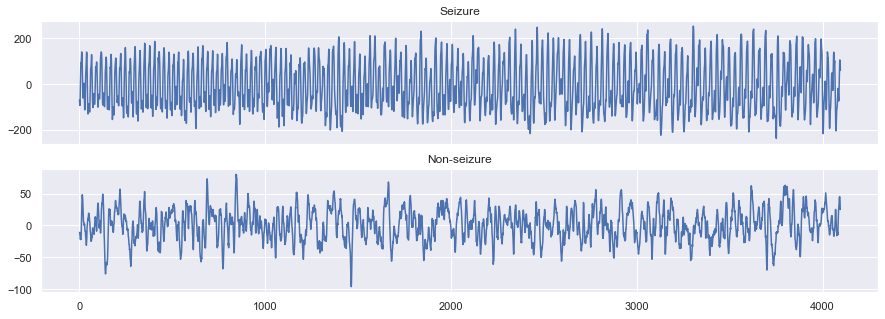

In [105]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 5))
ax1.plot(df4.iloc[:, 457])
ax1.set_title('Seizure')
ax2.plot(df4.iloc[:, 169])
ax2.set_title('Non-seizure')

# 3. split data into train, validation, test

In [163]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=47, 
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=TEST_SIZE, 
                                                  stratify=y_train,
                                                  random_state=47)

print('Feature DataFrame')
print('Training size: ' + str(X_train.shape))
print('Validation size: ' + str(X_val.shape))
print('Test size: ' + str(X_test.shape))
print('\nTarget DataFrame')
print('Training size: ' + str(y_train.shape))
print('Validation size: ' + str(y_val.shape))
print('Test size: ' + str(y_test.shape))

Feature DataFrame
Training size: (320, 29)
Validation size: (80, 29)
Test size: (100, 29)

Target DataFrame
Training size: (320, 1)
Validation size: (80, 1)
Test size: (100, 1)


### Lets just check that the proportions of a class membership is in the split data (1st column being class label and 2nd being count)

In [79]:
def get_proportions(data):

    counts = pd.DataFrame(np.unique(data, return_counts=True), index = ['Class_ID', 'Counts']).T
    counts['Percent'] = (counts['Counts']/counts['Counts'].sum()).round(2)*100
    counts = counts.set_index('Class_ID')
    return counts


In [118]:
display(get_proportions(y_train))
display(get_proportions(y_val))
display(get_proportions(y_test))

,Counts,Percent
Class_ID,,
0,256,80.0
1,64,20.0


,Counts,Percent
Class_ID,,
0,64,80.0
1,16,20.0


,Counts,Percent
Class_ID,,
0,80,80.0
1,20,20.0


we have the same ratios of classes in train and test because we split the data by stratifying on y 

### Standarize the X_train by fitting a StandardScaler

In [125]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)


# Lets plot two features against one another for the two classes

In [126]:
from sklearn.preprocessing import LabelEncoder

# make a label encoder
le = LabelEncoder()

feature_reduced_drop = X_copy.drop(['class'], axis='columns')
# change to an array
data_x = feature_reduced_drop.values
# change the string labels to ints
data_y = le.fit_transform(X_copy['class'])

feature_list = list(feature_reduced_drop.columns)

x_axis_label = 'D3_Ratio'
y_axis_label = 'D4_Ratio'

reduced_array = X_train_scale[:,[feature_list.index(x_axis_label),feature_list.index(y_axis_label)]]
reduced_df = pd.DataFrame(reduced_array, columns=[x_axis_label, y_axis_label])

reduced_df.head()

,D3_Ratio,D4_Ratio
0,-0.636941,-0.992380
1,-0.023182,2.705587
2,-0.978885,-0.631837
3,0.418123,-0.648436
4,-0.576419,-0.925091


# plot the data

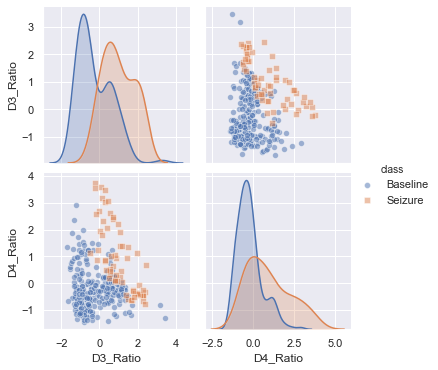

In [127]:
import seaborn as sns; sns.set(color_codes=True)

def plot_pairplot(data_x, data_y):

    data_plot = data_x.copy()
    data_plot['class'] = np.vectorize({0:'Baseline', 1:'Seizure'}.get)(data_y)
    sns.pairplot(data_plot, 
                 hue = 'class', 
                 hue_order = ['Baseline','Seizure'],
                 markers=["o", "s"], 
                 plot_kws=dict(alpha = 0.5))
    plt.show()
    
plot_pairplot(reduced_df, y_train)

# 4. Modeling 

### logistic regression
Logistic regression is a linear model for classification of a dependent variable which has a limited number of possible values. Logistic regression is a probabilistic model, using an odds ratio to determine the probability of the categorisation of an event. In binary classification, if the estimated probability is greater than 50% then the instance is predicted to be the positive class, otherwise the negative class is predicted.

Lets first see how we would fit a Logistic Regression model to our data

In [128]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

In [129]:
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

pipe_reg = Pipeline([('scl', StandardScaler()),
                     ('clf', LogisticRegression(C=100, 
                                                solver='liblinear',
                                                class_weight='balanced',
                                                random_state=47))])

pipe_reg

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LogisticRegression(C=100, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=47,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [133]:
pipe_reg.fit(X_train, y_train)
print('Validation Accuracy: %.3f' % pipe_reg.score(X_val, y_val))

Validation Accuracy: 0.963


In [134]:
log_predicted = pipe_reg.predict(X_val)
log_predicted

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [135]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Compare different models using some useful metrics beyond accuracy

In [136]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


RANDOM_STATE=47

# Logistic Regression
pipe_reg = Pipeline([('scl', StandardScaler()),
                     ('clf', LogisticRegression(class_weight='balanced',
                                                solver = 'liblinear',
                                                random_state=RANDOM_STATE))])

# Support Vector Machine
pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(kernel='rbf', 
                                class_weight = 'balanced',
                                probability=True,
                                random_state=RANDOM_STATE))])

# Decision Tree
DT = DecisionTreeClassifier(random_state=RANDOM_STATE, 
                            class_weight = 'balanced')

# Random Forest
rt = RandomForestClassifier(random_state=RANDOM_STATE, 
                            class_weight = 'balanced')


# K-Nearest Neighbours
pipe_kkn = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier())])

# list of classifier names
classifier_names = ['Logistic Regression', 'Support Vector Machine', 
                    'Decision Tree', 'Random Forest', 'K-Nearest Neighbors',
                   'XGBoost']

# list of classifiers
classifiers = [pipe_reg, pipe_svc, DT, rt, pipe_kkn]

# fit all the classifiers to the training data
for classifier in classifiers:
    classifier.fit(X_train, y_train)

## show confusion matrix

In [137]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [138]:
# evaluate logistic regression  
predictions = classifiers[0].predict(X_val)

confmat = confusion_matrix(y_true=y_val, y_pred=predictions)
confmat

array([[58,  6],
       [ 0, 16]])

[[58  6]
 [ 0 16]]


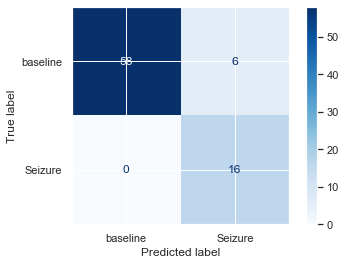

In [139]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(pipe_reg, X_val, y_val,
                                 display_labels=['baseline', 'Seizure'],
                                 cmap=plt.cm.Blues)
print(disp.confusion_matrix)

# Calculate recall and precision

Using the confusion matrix we can manuall work out a number of different performance metrics

## Error and Accuracy

Give general performance information regarding the number of all correct or false predictions comparative to the total number of predictions for both the positive and negative labels.

## Recall (or True Positive Rate)

Calculates how many of the actual positives our model correctly or incorrectly labelled. This is useful when the fraction of correctly or misclassified samples in the positive class are of interest.

## Precision (PRE)

Precision gives information on how precise your model is by looking at how many positive predicted labels are actually positive. To calculate it you just take the true positives and divide it by the total true and false positives. Precision is a good measure to determine, when the costs of a False Positive is high.

## F1-score

F1-score is a combination of Recall and Precision used when there is an uneven class distribution due to a large number of Actual Negatives that you are not as focused on.


Different metrics maybe more appropriate depending on the application. For example, the priority may be to identify seizures and not as much on correctly identifying inter-ictal periods, therefore recall would be a better metic to look at. 

In [140]:
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

ERR = (FP+FN)/(FP+FN+TP+TN)
ACC = 1-ERR
TPR = TP/(FN+TP)
FPR = FP/(FP+TN)
PRE = TP/(TP+FP)
REC = TP/(FN+TP)
F1 = 2*((PRE*REC)/(PRE+REC))

print('True positive rate (TPR): %.3f' % TPR)
print('False positive rate (FPR): %.3f' % FPR)
print('Error (ERR): %.3f' % ERR)
print()
print('Accuracy (ACC): %.3f' % ACC)
print('Precision (PRE): %.3f' % PRE)
print('Recall (REC): %.3f' % REC)
print('F1-score (F1): %.3f' % F1)

True positive rate (TPR): 1.000
False positive rate (FPR): 0.094
Error (ERR): 0.075

Accuracy (ACC): 0.925
Precision (PRE): 0.727
Recall (REC): 1.000
F1-score (F1): 0.842


# Sklearn can calculate these metrics for us

In [141]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

print('Accuracy (ACC): %.3f' % accuracy_score(y_true=y_val, y_pred=predictions))
print('Precision (PRE): %.3f' % precision_score(y_true=y_val, y_pred=predictions))
print('Recall (REC): %.3f' % recall_score(y_true=y_val, y_pred=predictions))
print('F1-score (F1): %.3f' % f1_score(y_true=y_val, y_pred=predictions))

Accuracy (ACC): 0.925
Precision (PRE): 0.727
Recall (REC): 1.000
F1-score (F1): 0.842


In [38]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(y_val, 
                                   predictions, 
                                   labels=None, 
                                   target_names=['Baseline', 'Seizure'], 
                                   sample_weight=None, 
                                   digits=2, 
                                   output_dict=True))

,Baseline,Seizure,accuracy,macro avg,weighted avg
precision,1.00000,0.727273,0.925,0.863636,0.945455
recall,0.90625,1.000000,0.925,0.953125,0.925000
f1-score,0.95082,0.842105,0.925,0.896462,0.929077
support,64.00000,16.000000,0.925,80.000000,80.000000


# combine the metrics for all models into one big dataframe

In [142]:
for i, classifier in enumerate(classifiers):
    predictions = classifier.predict(X_val)
    
    classifier_score_df = pd.DataFrame(
                        classification_report(y_val,
                                             predictions,
                                             target_names=['Baseline',
                                                           'Seizure'],
                                             digits=2,
                                             output_dict=True))
    classifier_score_df.index.name = 'Metric'
    classifier_score_df['Classifier'] = classifier_names[i]
    classifier_score_df = classifier_score_df.set_index('Classifier', append=True)
  
    if i == 0:
        all_scores = classifier_score_df

    else:
        all_scores = pd.concat([all_scores, classifier_score_df])
        
all_scores.sort_index()

Baseline    Seizure  accuracy  macro avg  \
Metric    Classifier                                                          
f1-score  Decision Tree            0.960630   0.848485    0.9375   0.904557   
          K-Nearest Neighbors      0.946565   0.758621    0.9125   0.852593   
          Logistic Regression      0.950820   0.842105    0.9250   0.896462   
          Random Forest            0.953846   0.800000    0.9250   0.876923   
          Support Vector Machine   0.942149   0.820513    0.9125   0.881331   
precision Decision Tree            0.968254   0.823529    0.9375   0.895892   
          K-Nearest Neighbors      0.925373   0.846154    0.9125   0.885763   
          Logistic Regression      1.000000   0.727273    0.9250   0.863636   
          Random Forest            0.939394   0.857143    0.9250   0.898268   
          Support Vector Machine   1.000000   0.695652    0.9125   0.847826   
recall    Decision Tree            0.953125   0.875000    0.9375   0.914062   
          K-Nearest Neighbors      0.968750   0.687500    0.9125   0.828125   
          Logistic Regression      0.906250   1.000000    0.9250   0.953125   
          Random Forest            0.968750   0.750000    0.9250   0.859375   
          Support Vector Machine   0.890625   1.000000    0.9125   0.945312   
support   Decision Tree           64.000000  16.000000    0.9375  80.000000   
          K-Nearest Neighbors     64.000000  16.000000    0.9125  80.000000   
          Logistic Regression     64.000000  16.000000    0.9250  80.000000   
          Random Forest           64.000000  16.000000    0.9250  80.000000   
          Support Vector Machine  64.000000  16.000000    0.9125  80.000000   

                                  weighted avg  
Metric    Classifier                            
f1-score  Decision Tree               0.938201  
          K-Nearest Neighbors         0.908976  
          Logistic Regression         0.929077  
          Random Forest               0.923077  
          Support Vector Machine      0.917822  
precision Decision Tree               0.939309  
          K-Nearest Neighbors         0.909529  
          Logistic Regression         0.945455  
          Random Forest               0.922944  
          Support Vector Machine      0.939130  
recall    Decision Tree               0.937500  
          K-Nearest Neighbors         0.912500  
          Logistic Regression         0.925000  
          Random Forest               0.925000  
          Support Vector Machine      0.912500  
support   Decision Tree              80.000000  
          K-Nearest Neighbors        80.000000  
          Logistic Regression        80.000000  
          Random Forest              80.000000  
          Support Vector Machine     80.000000

### looks like Random forest is the best across the board

# Receiver Operating Characteristic (ROC) Curve

We can also use plots to visualise each models performance.

ROC curves are useful for comparing classification models based on their false positive and true positive rate performance. A ROC curve is computed by shifting the decision threshold of the classifier

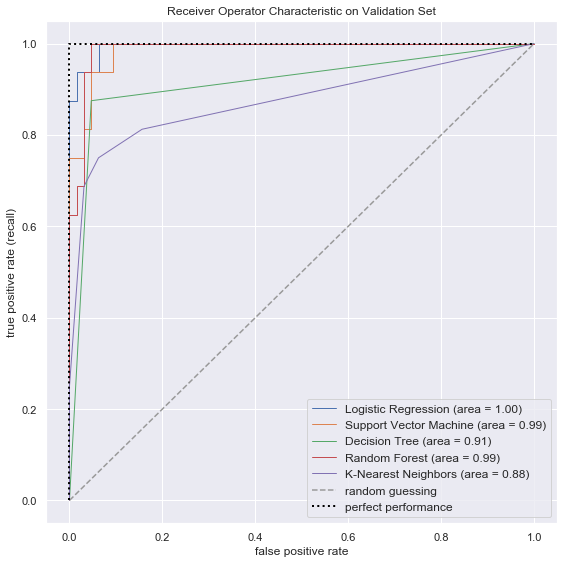

In [143]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.externals import joblib
import re

def ROC(classifiers, classifier_names, X_train, X_val, y_train, y_val):
  
    # this creates the matplotlib graph to make the confmat look nicer
    fig, ax = plt.subplots(figsize=(8, 8))
    # for each classifier...
    for i, classifer in enumerate(classifiers):
        # fit the pipeline
        probas = classifer.fit(X_train, y_train).predict_proba(X_val)

        # get the roc curve info
        fpr, tpr, thresholds = roc_curve(y_val, 
                                         probas[:, 1], 
                                         pos_label=1)

        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, 
                 tpr, 
                 lw=1, 
                 label='{} (area = %0.2f)'.format(classifier_names[i]) %roc_auc)

    plt.plot([0, 1], 
           [0, 1], 
           linestyle='--', 
           color=(0.6, 0.6, 0.6), 
           label='random guessing')

    plt.plot([0, 0, 1], 
           [0, 1, 1], 
           lw=2, 
           linestyle=':', 
           color='black', 
           label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate (recall)')
    plt.title('Receiver Operator Characteristic on Validation Set')
    plt.legend(loc="lower right", fontsize ='medium')

    plt.tight_layout()
    plt.show()    
    

ROC(classifiers, classifier_names, X_train, X_val, y_train, 
    y_val)

# precision recall curve

In [144]:
from sklearn.metrics import precision_recall_curve
#from sklearn.utils.fixes import signature
from sklearn.externals import joblib
from sklearn.metrics import average_precision_score

def Precision_Curve(classifier_list, classifier_names, X_train, 
                    X_val, y_train, y_val):

  # for each classifier...
    for i, classifer_ in enumerate(classifier_list):

        y_score = classifer_.decision_function(X_val)

        precision, recall, _ = precision_recall_curve(y_val, y_score)

        average_precision = average_precision_score(y_val, y_score)

        plt.step(recall, precision, where='post', 
           label=classifier_names[i]+' PREC = %0.2f'% average_precision)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve on Validation Set')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

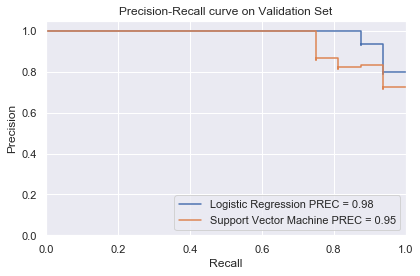

In [145]:
Precision_Curve(classifiers[:2], classifier_names[:2], X_train, X_val, 
                y_train, y_val)

## Precision Curves only work with classifiers that have a decision_function such as SVM

The precision-recall curve shows the tradeoff between precision and recall for different decision thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate (predict 1 instead of a 0) and high recall rlate to a low false negative rate (predict 0 instead of 1). 

## High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

High precision = we are predicting seizure when we should be predicting seizures, i.e not predicting 1 when it should be 0). This is like not assigning the wrong class.
High recall = out of all the true seizures, we are correctly predicting them all. This is like how many seizures from the true dataset are you able to recall.

# Lets try using XGBoost

In [164]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [165]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [166]:
# define model
model = xgb.XGBClassifier(objective='binary:logistic', missing=None)
# define evaluation procedure
cv = StratifiedKFold(n_splits=5, random_state=1)

# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [149]:
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.99383


In [167]:
model.fit(X_train, 
        y_train, 
        verbose=True,
        early_stopping_rounds=10,
        eval_metric='aucpr',
        eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.76850
[1]	validation_0-aucpr:0.84435
[2]	validation_0-aucpr:0.95268
[3]	validation_0-aucpr:0.98945
[4]	validation_0-aucpr:0.98945
[5]	validation_0-aucpr:0.98945
[6]	validation_0-aucpr:0.99047
[7]	validation_0-aucpr:0.98534
[8]	validation_0-aucpr:0.97993
[9]	validation_0-aucpr:0.98047
[10]	validation_0-aucpr:0.98845
[11]	validation_0-aucpr:0.98845
[12]	validation_0-aucpr:0.99047
[13]	validation_0-aucpr:0.98635
[14]	validation_0-aucpr:0.98635
[15]	validation_0-aucpr:0.99047
[16]	validation_0-aucpr:0.99047


/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [168]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)

pd.DataFrame(classification_report(y_test, 
                                   predictions, 
                                   labels=None, 
                                   target_names=['Baseline', 'Seizure'], 
                                   sample_weight=None, 
                                   digits=2, 
                                   output_dict=True))

,Baseline,Seizure,accuracy,macro avg,weighted avg
precision,1.000000,0.909091,0.98,0.954545,0.981818
recall,0.975000,1.000000,0.98,0.987500,0.980000
f1-score,0.987342,0.952381,0.98,0.969861,0.980350
support,80.000000,20.000000,0.98,100.000000,100.000000


# XGBoost is overfitting to the training data. Observe training and validation curves

In [169]:
from sklearn.externals import joblib
from sklearn.model_selection  import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
import numpy as np

StratKFold = StratifiedKFold(n_splits = 5,
                             shuffle=False,
                             random_state=0)

SCORER = make_scorer(score_func=f1_score)


def Grid_Search(X_train, y_train, estimator, cv, 
                param_grid, scorer):

    # create gridsearch object
    gs = GridSearchCV(estimator=estimator, 
                    param_grid=param_grid, 
                    scoring=scorer, 
                    cv=cv,
                    return_train_score=True,
                    refit = True,
                    n_jobs=-1)

    # fit the gridsearch object
    gs = gs.fit(X_train, 
                y_train, 
                early_stopping_rounds=10,
                eval_metric='aucpr',
                eval_set=[(X_test, y_test)])

    # get the results of the gridsearch
    results = pd.DataFrame(gs.cv_results_)

    # select the best estimator
    clf_pipe = gs.best_estimator_

    display(results[['mean_fit_time','mean_score_time',
                   'params','mean_test_score',
                   'std_test_score']].sort_values(by='mean_test_score',
                                                  ascending =False))

    return clf_pipe, results


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [153]:
model = xgb.XGBClassifier(use_label_encoder=False)
param_grid = {
    'n_estimators': [400, 800, 1000],
}

SCORER = make_scorer(score_func=f1_score)

# scorers = {
#             'f1_score':make_scorer(f1_score),
#             'precision_score': make_scorer(precision_score),
#             'recall_score': make_scorer(recall_score),
#             'accuracy_score': make_scorer(accuracy_score)
#           }

StratKFold = StratifiedKFold(n_splits = 5,
                             shuffle=True,
                             random_state=0)

grid = GridSearchCV(model, 
                    param_grid=param_grid, 
                    scoring=SCORER, 
                    cv=StratKFold,
                    return_train_score=True);

grid.fit(X_train, y_train);
# Dictionary of best parameters
best_pars = grid.best_params_;

[09:43:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:43:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:43:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:43:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [170]:
# get the results of the gridsearch
results = pd.DataFrame(grid.cv_results_)

# select the best estimator
clf_pipe = grid.best_estimator_

display(results[['mean_fit_time','mean_score_time',
               'params','mean_test_score',
               'std_test_score']].sort_values(by='mean_test_score',
                                              ascending =False))

,mean_fit_time,mean_score_time,params,mean_test_score,std_test_score
0,0.131497,0.003173,{'n_estimators': 400},0.901333,0.042405
1,0.245715,0.003315,{'n_estimators': 800},0.901333,0.042405
2,0.338218,0.003924,{'n_estimators': 1000},0.901333,0.042405


In [171]:
clf_pipe.fit(X_test, y_test)

[09:48:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [172]:
from sklearn.metrics import classification_report
predictions = clf_pipe.predict(X_test)

pd.DataFrame(classification_report(y_test, 
                                   predictions, 
                                   labels=None, 
                                   target_names=['Baseline', 'Seizure'], 
                                   sample_weight=None, 
                                   digits=2, 
                                   output_dict=True))

,Baseline,Seizure,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,80.0,20.0,1.0,100.0,100.0


In [177]:
clf_pipe.predict(X_test).T

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [178]:
y_test.T

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [179]:
summary = results[['param_n_estimators', 'mean_train_score', 'mean_test_score']]

In [180]:
summary_long = pd.melt(summary, 
                       id_vars=['param_n_estimators'],
                       value_vars=['mean_train_score', 
                                   'mean_test_score'],
                        var_name='metric',
                      value_name='score')

In [181]:
display(summary_long)

,param_n_estimators,metric,score
0,400,mean_train_score,1.000000
1,800,mean_train_score,1.000000
2,1000,mean_train_score,1.000000
3,400,mean_test_score,0.901333
4,800,mean_test_score,0.901333
5,1000,mean_test_score,0.901333


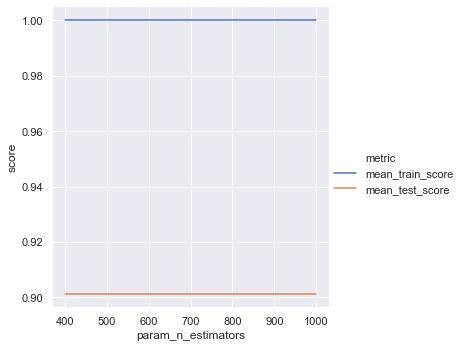

In [182]:
g = sns.relplot(data=summary_long,
               x = 'param_n_estimators',
               y ='score',
#                row='param_clf__min_samples_split',
#                col='param_clf__n_estimators',
               hue='metric',
               kind='line')